## g-PINN for solving the following ODEs
$$\left\{ \begin{array}{l}
\dfrac{{du}}{{dx}} = \cos (wx),\,\,\,\,\,x \in \Omega ,\\
u(0) = 0,
\end{array} \right.$$
Exact solution is
$u(x)=\dfrac{1}{w}\sin(wx)$

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [29]:
tf.random.set_seed(0)
np.random.seed(0)

In [30]:
# Define f(x) and its derivative f'(x)
w = 1

def f(x):
    return  -(np.pi**2)*tf.sin(np.pi*x)

def df(x):
    return  -np.pi*(np.pi**2)*tf.cos(np.pi*x)

In [31]:
# Neural network model
class gPINN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(50, activation='tanh'),
            tf.keras.layers.Dense(50, activation='tanh'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, x):
        return self.model(x)

In [32]:
# Loss function: PDE + gradient of residual + boundary
def compute_loss(model, X_c, X_b, u_b):
    with tf.GradientTape(persistent=True) as t3:
        t3.watch(X_c)
        with tf.GradientTape(persistent=True) as t2:
            t2.watch(X_c)
            with tf.GradientTape() as t1:
                t1.watch(X_c)
                u = model(X_c)
            u_x = t1.gradient(u, X_c)
        u_xx = t2.gradient(u_x, X_c)
    u_xxx = t3.gradient(u_xx, X_c)

    # Compute residual and gradient of residual
    r = u_xx - f(X_c)
    r_x = u_xxx - df(X_c)

    loss_pde = tf.reduce_mean(tf.square(r))
    loss_grad = tf.reduce_mean(tf.square(r_x))
    u_b_pred = model(X_b)
    loss_bc = tf.reduce_mean(tf.square(u_b_pred - u_b))

    total_loss = loss_pde +loss_grad  + loss_bc
    return total_loss, loss_pde, loss_grad, loss_bc

In [33]:
# Training step
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss, l_pde, l_grad, l_bc = compute_loss(model, X_c, X_b, u_b)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, l_pde, l_grad, l_bc

In [34]:
# Domain points
N_c = 100
X_c = tf.reshape(tf.linspace(0.0, 1, N_c), (-1, 1))
X_b = tf.constant([[0.0], [1]], dtype=tf.float32)
u_b = tf.constant([[0.0], [0.0]], dtype=tf.float32)

# Instantiate model
model = gPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [35]:
# Train
for epoch in range(10000):
    loss, l_pde, l_grad, l_bc = train_step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch:4d} | Total: {loss:.5e} | PDE: {l_pde:.2e} | GradRes: {l_grad:.2e} | BC: {l_bc:.2e}")

Epoch    0 | Total: 5.33049e+02 | PDE: 4.81e+01 | GradRes: 4.85e+02 | BC: 1.26e-03
Epoch  500 | Total: 2.98285e-01 | PDE: 4.03e-02 | GradRes: 2.18e-01 | BC: 4.05e-02
Epoch 1000 | Total: 1.24673e-02 | PDE: 2.37e-04 | GradRes: 1.18e-02 | BC: 3.91e-04
Epoch 1500 | Total: 3.98710e-03 | PDE: 7.11e-05 | GradRes: 3.89e-03 | BC: 2.99e-05
Epoch 2000 | Total: 1.31977e-03 | PDE: 7.01e-06 | GradRes: 1.31e-03 | BC: 3.55e-06
Epoch 2500 | Total: 1.37393e-03 | PDE: 2.18e-05 | GradRes: 1.35e-03 | BC: 7.89e-08
Epoch 3000 | Total: 9.19089e-04 | PDE: 1.60e-06 | GradRes: 9.17e-04 | BC: 2.18e-07
Epoch 3500 | Total: 6.03027e-03 | PDE: 2.56e-04 | GradRes: 5.77e-03 | BC: 1.60e-06
Epoch 4000 | Total: 1.42763e-03 | PDE: 3.33e-05 | GradRes: 1.39e-03 | BC: 2.23e-07
Epoch 4500 | Total: 8.06809e-04 | PDE: 3.69e-06 | GradRes: 8.03e-04 | BC: 4.35e-07
Epoch 5000 | Total: 1.76630e-03 | PDE: 5.17e-05 | GradRes: 1.71e-03 | BC: 4.20e-08
Epoch 5500 | Total: 6.97453e-04 | PDE: 1.14e-06 | GradRes: 6.96e-04 | BC: 4.47e-07
Epoc

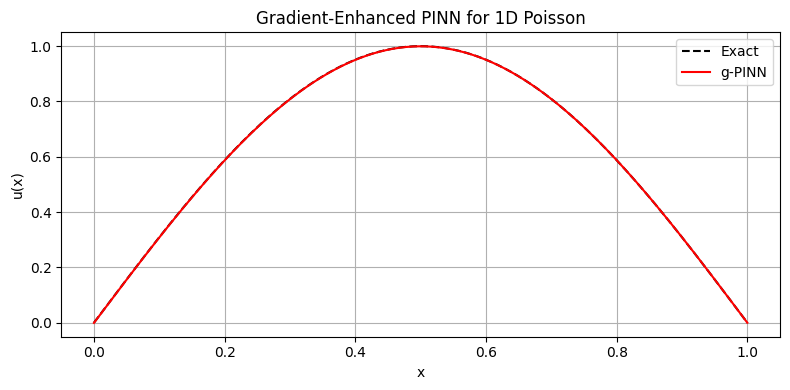

In [37]:
# Evaluate
x_test = tf.reshape(tf.linspace(0.0, 1, 200), (-1, 1))
u_pred = model(x_test)
u_true = tf.sin(np.pi*x_test)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_test, u_true, 'k--', label='Exact')
plt.plot(x_test, u_pred, 'r', label='g-PINN')
plt.title("Gradient-Enhanced PINN for 1D Poisson")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()